In [1]:
%matplotlib inline
%pdb on

from pprint import pprint
import itertools
import numpy

from metrics import wer, cew, ssr, average, hreff
import montecarlo
import dms
import withdrawal
import mortality
from portfolio import Portfolio
from harvesting import make_rebalancer, PrimeHarvesting
from decimal import Decimal as D

import plot
from matplotlib import pyplot as plt

import pandas

Automatic pdb calling has been turned ON


In [2]:
survival_function = mortality.make_mortality(mortality.ANNUITY_2000)

In [3]:
def run_one_new(dataset, strategy, hreff_floor=3, debug_cashflows=False):
    p = Portfolio(600000, 400000)
    h = make_rebalancer(.6)(p).harvest()
    h.send(None)
    w = strategy(p, h).withdrawals()

    cashflows = []
    returns = []

    # Initial withdrawal at start of retirement
    annual = w.send(None)
    cashflows.append(annual.withdraw_pct_orig)
    
    debug = []

    for i in dataset:
        annual = w.send(i)
        returns.append(annual.returns)
        cashflows.append(annual.withdraw_pct_orig)

        if debug_cashflows:
            debug.append({
                'Returns' : annual.returns,
                'Withdraw' : annual.withdraw_n,
                'Portfolio' : annual.portfolio_n,
            })

    if debug_cashflows:
        pandas.DataFrame(data=debug).to_csv('WERCOMP-cashflows.csv')

    w = wer(cashflows, returns)
    h = hreff(cashflows, returns, floor=D(hreff_floor)/100)
    return (w, h, returns)

In [4]:
%timeit
def new_calc(strategies, runs=1000, dataset=montecarlo.historical[60]):
    wer_df = pandas.DataFrame(index=numpy.arange(0, runs), columns=[s.__name__ for s in strategies])
    hreff_df = pandas.DataFrame(index=numpy.arange(0, runs), columns=[s.__name__ for s in strategies])
    returns_df = pandas.DataFrame(index=numpy.arange(0, runs), columns=[i for i in range(60)])

    for i in range(runs):
        # First generate a lifespan, so we know how many years of returns we need to generate
        lifespan = mortality.gen_lifespan(mortality.DEFAULT_COUPLE, survival_function)

        returns = (dataset.random_year() for y in range(lifespan))
        pairs = zip(strategies, itertools.tee(returns, len(strategies)))
      
        for (s, r) in pairs:
            (wer, hreff, returns) = run_one_new(r, s)
            wer_df.loc[i][s.__name__] = wer
            hreff_df.loc[i][s.__name__] = hreff
            
            returns_df.loc[i] = returns + [None for _ in range(60-lifespan)]
            
    return (wer_df, hreff_df, returns_df)

In [5]:
def VPW(p, h):
    return withdrawal.VPW(p, h, replan=True)

strategies = [
    withdrawal.SensibleWithdrawals,
    withdrawal.FloorCeiling,
    withdrawal.Guyton,
    withdrawal.Clyatt,
    withdrawal.Vanguard,
    withdrawal.TiltCapital,
    withdrawal.IRS_RMD,
    withdrawal.FeelFree,
    withdrawal.ARVA,
    VPW,
    withdrawal.InvertedWithdrawals,
    withdrawal.SimpleFormula,
    withdrawal.RetrenchmentRule,
    withdrawal.ConstantPercentage,
    withdrawal.ConstantWithdrawals,
    withdrawal.EM,
    withdrawal.ECM,
    withdrawal.Model3,
]
wer_df, hreff_df, returns_df = new_calc(strategies, runs=1, dataset=montecarlo.conservative[60])

In [6]:
#returns_df.to_csv('WERCOMP-returns.csv')
#wer.to_csv('WERCOMP-wer.csv')
#hreff.to_csv('WERCOMP-hreff.csv')

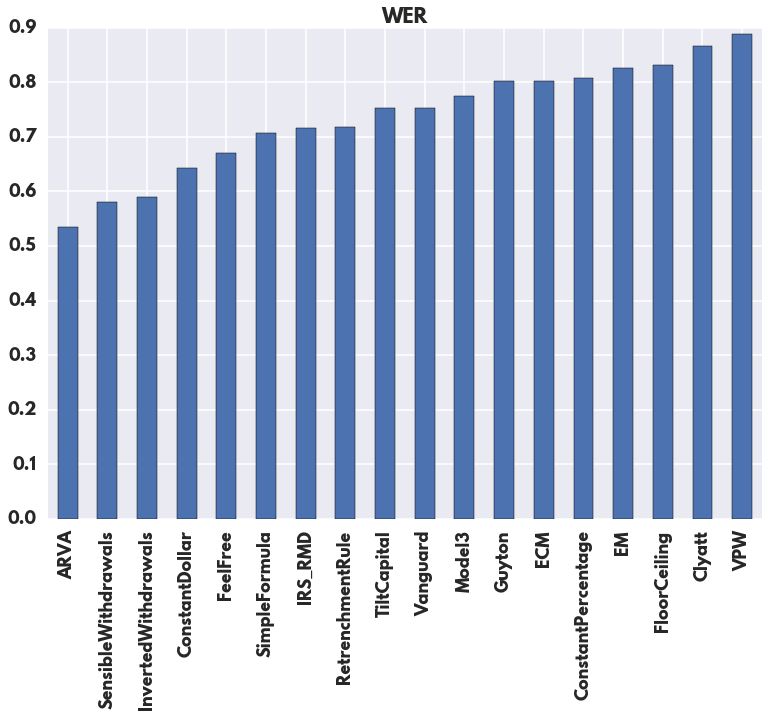

In [7]:
d = [(col, series.mean()) for (col, series) in wer_df.iteritems()]
series = pandas.Series(dict(d))

series.sort_values(inplace=True)
series.plot(kind='bar', title='WER')
#print(series)

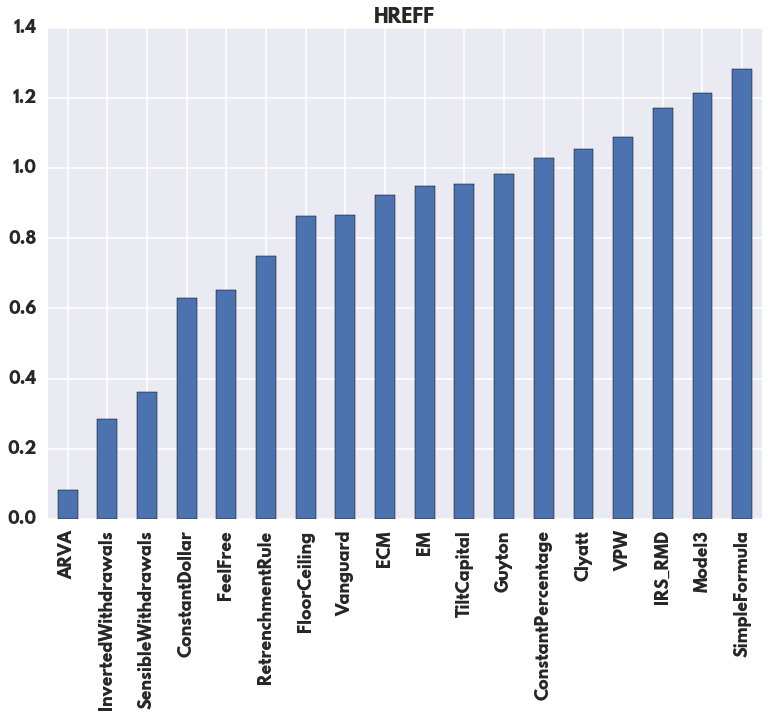

In [8]:
d = [(col, series.mean()) for (col, series) in hreff_df.iteritems()]
series = pandas.Series(dict(d))

series.sort_values(inplace=True)
series.plot(kind='bar', title='HREFF')

In [11]:
import math
import adt
from decimal import Decimal

RETURNS = pandas.read_csv('WERCOMP-returns.csv')

def replay(row):
    for i in row[1:]:
        if math.isnan(i):
            raise StopIteration
        yield adt.AnnualChange(year=0, stocks=Decimal(i), bonds=Decimal(i), inflation=0)
_ = run_one_new(replay(RETURNS.iloc[0]), withdrawal.Guyton, debug_cashflows=True)
float(_[1])

0.01388587893434898